# Forecasting

The data provided is a time series from smart-meters in London from end of 2011 to 2014. It contains the daily consumption (kWh) averaged over several households in London.

The last timestamp for which consumpton is available is January 31st 2014.

You need to build a forecasting model that can predict the consumption for February 2014 (exluding 28th, so from the 1st to the 27th).

#### Setting and data import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.api import tsa
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#### Helper Functions

In [150]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [419]:
df = pd.read_csv("data/london_smartmeter_basic.csv")

In [420]:
df.head()

,day,consumption,evaluation_set
0,2011-11-24,7.7580,False
1,2011-11-25,8.7385,False
2,2011-11-26,9.4770,False
3,2011-11-27,9.8030,False
4,2011-11-28,7.0690,False


### Plot time series

In [421]:
time_series = df[df['evaluation_set'] == False].drop('evaluation_set', axis=1)
time_series['day'] = pd.to_datetime(time_series['day'])
time_series.set_index('day', inplace = True)

time_series

,consumption
day,
2011-11-24,7.7580
2011-11-25,8.7385
2011-11-26,9.4770
2011-11-27,9.8030
2011-11-28,7.0690
...,...
2014-01-27,8.8905
2014-01-28,8.5395
2014-01-29,8.8530


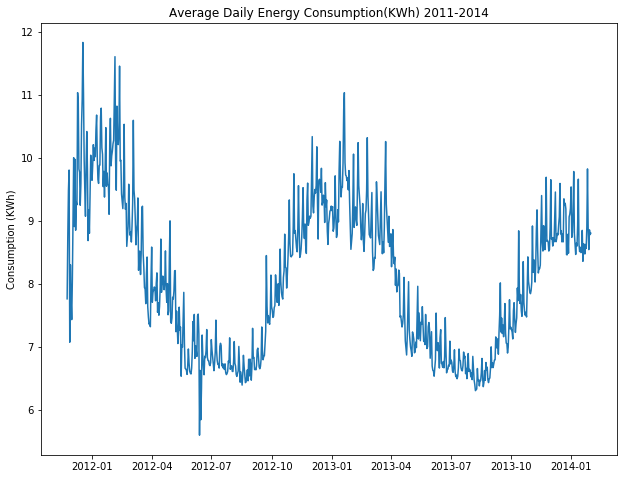

In [194]:
# plt.figure(figsize=(8, 6))
# plt.plot(time_series['consumption'])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])


ax.plot(time_series['consumption'])
ax.set_title("Average Daily Energy Consumption(KWh) 2011-2014")
ax.set_xlabel('')
# xticks = pd.to_datetime(time_series['day']).month
# ax.set_xticks()
ax.set_ylabel('Consumption (KWh)')
plt.show()

# plt.figure(figsize=(12, 3))
# plt.plot(bikes_monthly.temperature, "-o")

#### Check Outliers

In [494]:
time_series[time_series['consumption']<6.4]
time_series[(time_series.index >= pd.to_datetime('2012-06-13')) &(time_series.index <= pd.to_datetime('2012-06-16'))]

,consumption,date,is_holiday
day,,,
2012-06-13,5.5930,2012-06-13,False
2012-06-14,6.6210,2012-06-14,False
2012-06-15,5.8385,2012-06-15,False
2012-06-16,6.3345,2012-06-16,False


In [199]:
time_series[time_series['consumption']>10.5]

,consumption
day,
2011-12-10,11.0320
2011-12-11,10.8720
2011-12-16,10.5225
2011-12-17,10.9290
2011-12-18,11.8295
2011-12-19,11.0085
2012-01-08,10.6760
2012-01-14,10.6460
2012-01-15,10.7860


#### Resample by year and month

In [6]:
energy_yearly = time_series.resample('12M').mean()
energy_monthly = time_series.resample('M').mean()
energy_weekly  = time_series.resample('W').mean()
plt.figure(figsize=(12, 3))

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

#### Plot Resampled data

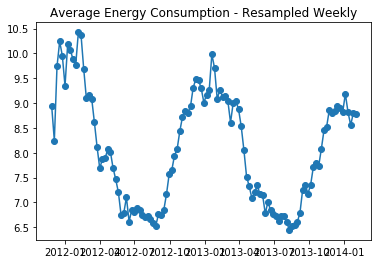

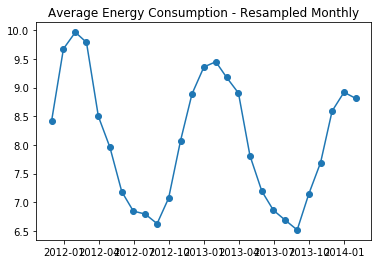

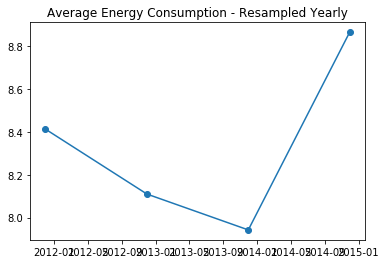

In [147]:
plt.plot(energy_weekly, "-o")
plt.title('Average Energy Consumption - Resampled Weekly')
plt.show()

plt.plot(energy_monthly, "-o")
plt.title('Average Energy Consumption - Resampled Monthly')
plt.show()

plt.plot(energy_yearly, "-o")
plt.title('Average Energy Consumption - Resampled Yearly')
plt.show()

#### Look at the rolling Average

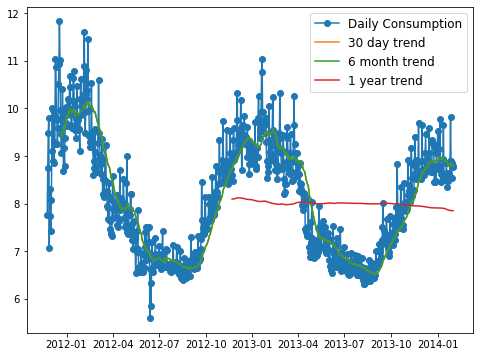

In [8]:
plt.figure(figsize=(8, 6))
rolling_mean30 = time_series.rolling(window=30).mean()
rolling_mean183 = time_series.rolling(window=183).mean()
rolling_mean365 = time_series.rolling(window=365).mean()

plt.plot(time_series, '-o', label='Daily Consumption')
plt.plot(rolling_mean30, label='30 day trend')
plt.plot(rolling_mean30, label='6 month trend')
plt.plot(rolling_mean365, label='1 year trend')
plt.legend(fontsize=12);

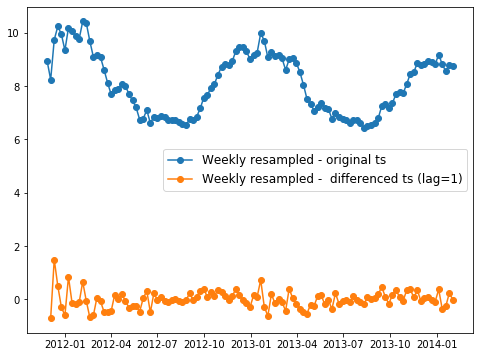

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(energy_weekly, '-o', 
         label="Weekly resampled - original ts")
plt.plot(energy_weekly.diff(1), '-o', 
         label="Weekly resampled -  differenced ts (lag=1)")
plt.legend(fontsize=12)

#### Autocorrelation

In [10]:
energy_weekly

,consumption
day,
2011-11-27,8.944125
2011-12-04,8.244500
2011-12-11,9.738286
2011-12-18,10.242429
2011-12-25,9.950714
...,...
2014-01-05,9.186000
2014-01-12,8.815357
2014-01-19,8.557143


C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


Text(0, 0.5, 'Autocorrelation')

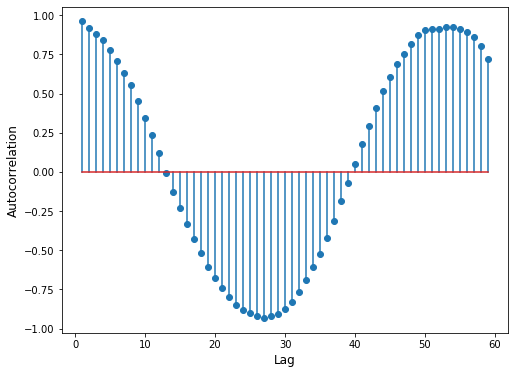

In [11]:
lags = range(1, 60)
autocorrs = [energy_weekly['consumption'].autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(8, 6))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

### Seasonal decomposition

In [12]:
time_series

,consumption
day,
2011-11-24,7.7580
2011-11-25,8.7385
2011-11-26,9.4770
2011-11-27,9.8030
2011-11-28,7.0690
...,...
2014-01-27,8.8905
2014-01-28,8.5395
2014-01-29,8.8530


In [262]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(time_series,freq=365,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



TypeError: float() argument must be a string or a number, not 'Timestamp'

### Stationarity Tests

In [14]:
# Stationarity tests
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
def test_stationarity(timeseries):

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(time_series['consumption'])

# Not Stationary!

Results of Dickey-Fuller Test:
Test Statistic                  -1.817350
p-value                          0.371883
#Lags Used                      21.000000
Number of Observations Used    778.000000
Critical Value (1%)             -3.438783
Critical Value (5%)             -2.865262
Critical Value (10%)            -2.568752
dtype: float64


#### Plot with trend and seasonality removed

TypeError: float() argument must be a string or a number, not 'datetime.timedelta'

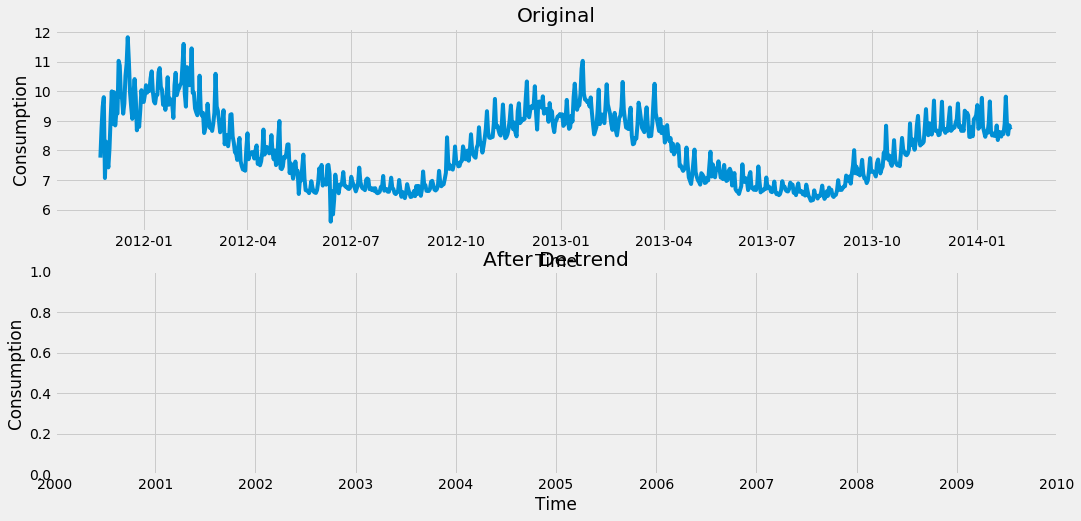

In [516]:
# ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
# ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(411)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.plot(time_series['consumption'])

plt.subplot(412)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Consumption')
# new_ts=difference(time_series['consumption'])
plt.plot(time_series.diff(1))
plt.plot()

plt.subplot(413)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
# new_ts=difference(time_series['consumption'],365)       # assuming the seasonality is 12 months long
plt.plot(time_series.diff(365))
plt.plot()
plt.tight_layout()


# Don't think you need to de trend for ARMA?
new_ts = time_series.diff(365).dropna()
new_ts

### Test Stationarity again

In [16]:
test_stationarity(new_ts['consumption'])

Results of Dickey-Fuller Test:
Test Statistic                  -4.563234
p-value                          0.000151
#Lags Used                      17.000000
Number of Observations Used    417.000000
Critical Value (1%)             -3.446129
Critical Value (5%)             -2.868496
Critical Value (10%)            -2.570475
dtype: float64


### Picking a model

Time Series plotting

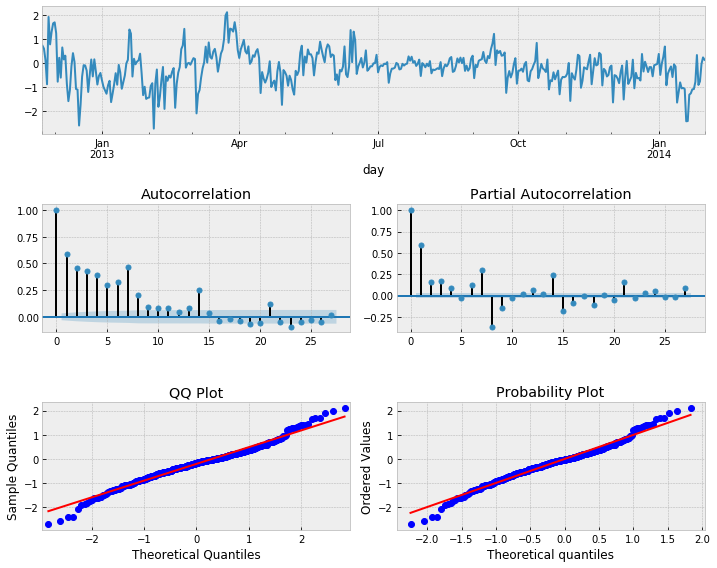

In [17]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

tsplot(new_ts['consumption'])

ACF Shape	Indicated Model
Exponential, decaying to zero	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model	
Alternating positive and negative, decaying to zero Autoregressive model.	Use the partial autocorrelation plot to help identify the order.	
One or more spikes, rest are essentially zero	Moving average model, order identified by where plot becomes zero.	
Decay, starting after a few lags	Mixed autoregressive and moving average (ARMA) model.	
All zero or close to zero	Data are essentially random.	
High values at fixed intervals	Include seasonal autoregressive term.	
No decay to zero	Series is not stationary

#### Autocorrelation plot

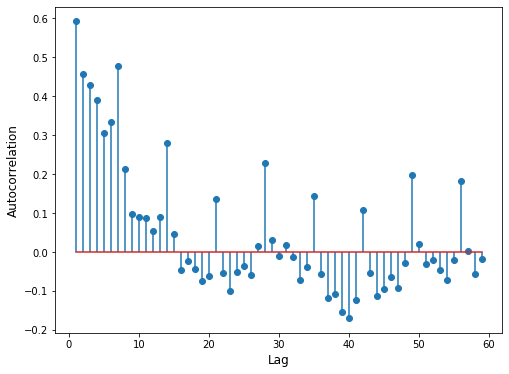

In [18]:
lags = range(1, 60)
autocorrs = [new_ts['consumption'].autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(8, 6))
plt.stem(lags, autocorrs, use_line_collection=True)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.show()

In [19]:
new_ts

,consumption
day,
2012-11-23,0.7210
2012-11-24,0.5945
2012-11-25,0.1190
2012-11-26,-0.8775
2012-11-27,1.9075
...,...
2014-01-27,-0.9045
2014-01-28,-0.7585
2014-01-29,-0.0380


#### AutoRegression Model

In [20]:
# Find the opt lag
ar = tsa.AR(new_ts['consumption'], freq = 'D')
optlag = ar.select_order(10, ic="aic")
print('Optimal p =', optlag) # 15 OR 9

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, Future

Optimal p = 9


#### Fit AR model 

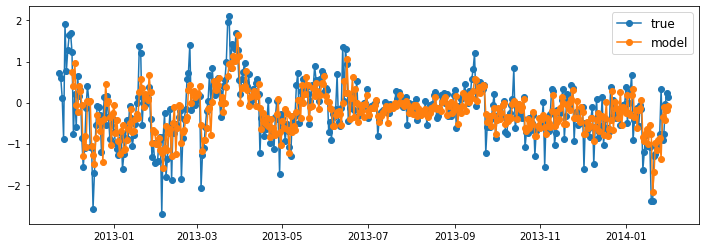

In [21]:
ar_result = ar.fit(maxlag=optlag)
prediction = ar_result.predict(start=optlag)

plt.figure(figsize=(12, 4))
plt.plot(new_ts['consumption'], '-o', label='true')
plt.plot(prediction, '-o', label='model')
plt.legend(fontsize=12);

In [148]:
print('MAE = {0:.3f}'.format(mean_absolute_error(new_ts['consumption'][optlag:], prediction)))  #15 0.313

MAE = 0.339


In [175]:
def Forecasting_crossValidation( time_series, training_size, optlag ):
    """
    Given a pd.Series we train a autoregressive model. 
    The number of training observation is specified by the variable training_size
    """
    train = time_series[:training_size]
    test = time_series[training_size:]
    ar = tsa.AR(train)
    ar_result = ar.fit(maxlag=optlag, freq = 'D')
    prediction = ar_result.predict(end=len(time_series))[-len(test):]

    
    # compute the MAE and the MAPE:
    mae = mean_absolute_error(time_series.values[training_size:], prediction)
    print(optlag, ' Mean absolute error: ' + str(mae)) 
    mape = mean_absolute_percentage_error(time_series.values[training_size:], prediction)
    print(optlag, ' Mean absolute percentage error: ' + str(mape))
    print(time_series.values[training_size:].size, prediction.size)
    # plot results as well:
    plt.plot(time_series.values, '-o', label='true')
    plt.plot(range(training_size, len(time_series)), prediction, 
         '-o', label='out of sample prediction')
    plt.legend();
    
    return prediction

9  Mean absolute error: 0.6211970252171822
9  Mean absolute percentage error: 133.5730051124139
35 35
9  Mean absolute error: 0.45588649234911827
9  Mean absolute percentage error: 144.06196295794336
135 135


C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)


C:\Users\rache\Anaconda3\envs\ads033\lib\

2013-09-20    0.322411
2013-09-21    0.391901
2013-09-22    0.440238
2013-09-23   -0.220410
2013-09-24    0.046682
                ...   
2014-01-28   -0.152134
2014-01-29   -0.152136
2014-01-30   -0.152139
2014-01-31   -0.152137
2014-02-01   -0.152135
Freq: D, Length: 135, dtype: float64

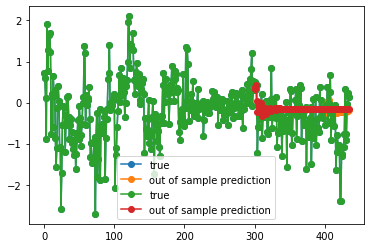

In [181]:
Forecasting_crossValidation(new_ts['consumption'],400,9) 
Forecasting_crossValidation(new_ts['consumption'],300,9) 
# Forecasting_crossValidation(new_ts['consumption'],400,15) 
# Forecasting_crossValidation(new_ts['consumption'],400,4) 

# new_ts['consumption'].values[400:]

#### ARMA MODEL

In [25]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(10)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts['consumption'], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))  #(9,4)

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequ

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequ

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided

aic: 564.31418 | order: (9, 4)


C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so infe

In [182]:
def Forecasting_crossValidationARMA( time_series, training_size, order  ):
    """
    Given a pd.Series we train a autoregressive model. 
    The number of training observation is specified by the variable training_size
    """
    train = time_series[:training_size]
    test = time_series[training_size:]
    arma = tsa.ARMA(train, order =order)
    arma_result = arma.fit()
    prediction = arma_result.predict(end=len(time_series))[-len(test):]
    
    # compute the MAE:
    mae = mean_absolute_error(time_series.values[training_size:], prediction)
    print( ' Mean absolute error: ' + str(mae))
    
    mape = mean_absolute_percentage_error(time_series.values[training_size:], prediction)
    print(' Mean absolute percentage error: ' + str(mape))
 
    
    # plot results as well:
    plt.plot(time_series.values, '-o', label='true')
    plt.plot(range(training_size, len(time_series)), prediction, 
         '-o', label='out of sample prediction')
    plt.legend();
    
    return prediction

In [27]:
# arma = tsa.ARMA(time_series, order=(3, 3))
# arma_result = arma.fit()
# prediction = arma_result.predict(start=3)

In [28]:
# arma = tsa.ARMA(new_ts['consumption'],(9,10), freq = 'D')


C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning:

overflow encountered in exp

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning:

overflow encountered in exp

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning:

invalid value encountered in true_divide



 Mean absolute error: 0.6828417990212406
 Mean absolute percentage error: 132.95329587951875


C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



 Mean absolute error: 0.6838352717461031
 Mean absolute percentage error: 211.83610641212286


C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rache\Anaconda3\envs\ads033\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



2013-12-29    0.023437
2013-12-30   -0.631032
2013-12-31   -0.479110
2014-01-01   -0.607363
2014-01-02   -0.302625
2014-01-03   -0.023831
2014-01-04   -0.159712
2014-01-05    0.111015
2014-01-06   -0.491953
2014-01-07   -0.312804
2014-01-08   -0.510559
2014-01-09   -0.231855
2014-01-10    0.066681
2014-01-11   -0.086657
2014-01-12    0.157928
2014-01-13   -0.443452
2014-01-14   -0.270414
2014-01-15   -0.488245
2014-01-16   -0.226901
2014-01-17    0.078676
2014-01-18   -0.076559
2014-01-19    0.168069
2014-01-20   -0.431716
2014-01-21   -0.263053
2014-01-22   -0.486831
2014-01-23   -0.235408
2014-01-24    0.075566
2014-01-25   -0.077621
2014-01-26    0.173080
2014-01-27   -0.424333
2014-01-28   -0.260257
2014-01-29   -0.487301
2014-01-30   -0.244449
2014-01-31    0.071116
2014-02-01   -0.079793
Freq: D, dtype: float64

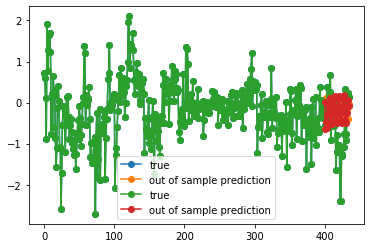

In [183]:
Forecasting_crossValidationARMA(new_ts['consumption'],400, (3,3)) 
Forecasting_crossValidationARMA(new_ts['consumption'],400, (9,4)) 


## Modelling - Prophet

In [263]:
from fbprophet import Prophet

#### Check the distribution and explore the data set 

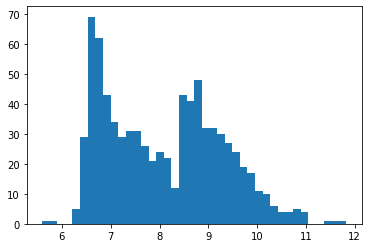

In [266]:
# Check distribution
plt.hist((time_series['consumption']), bins=40)
plt.show()

In [285]:
time_series

,consumption
day,
2011-11-24,7.7580
2011-11-25,8.7385
2011-11-26,9.4770
2011-11-27,9.8030
2011-11-28,7.0690
...,...
2014-01-27,8.8905
2014-01-28,8.5395
2014-01-29,8.8530


In [286]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['day'] = df.index
    df['dayofweek'] = df['day'].dt.dayofweek
    df['quarter'] = df['day'].dt.quarter
    df['month'] = df['day'].dt.month
    df['year'] = df['day'].dt.year
    df['dayofyear'] = df['day'].dt.dayofyear
    df['dayofmonth'] = df['day'].dt.day
    df['weekofyear'] = df['day'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(time_series, label='consumption')

features_and_target = pd.concat([X, y], axis=1)

In [287]:
# See our features and target
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,consumption
day,,,,,,,,
2011-11-24,3,4,11,2011,328,24,47,7.7580
2011-11-25,4,4,11,2011,329,25,47,8.7385
2011-11-26,5,4,11,2011,330,26,47,9.4770
2011-11-27,6,4,11,2011,331,27,47,9.8030
2011-11-28,0,4,11,2011,332,28,48,7.0690


#### Check the distribution

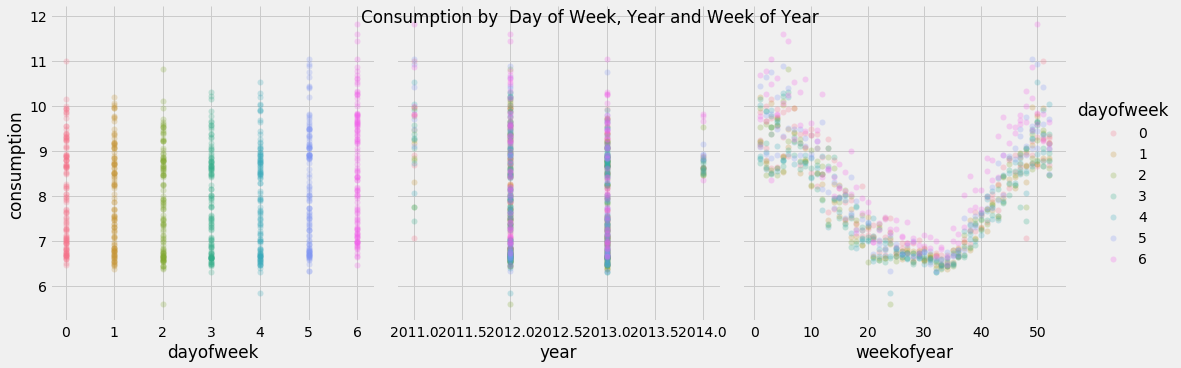

In [293]:
plt.style.use('fivethirtyeight') # For plots
sns.pairplot(features_and_target.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek',
                     'year','weekofyear'],
             y_vars='consumption',
             height=5,
             plot_kws={'alpha':0.25, 'linewidth':0}
            )
plt.suptitle('Consumption by  Day of Week, Year and Week of Year')
plt.show()

#### Define Split date fro validation

In [426]:
split_date = '01-Jan-2014'
train = time_series.loc[time_series.index <split_date].copy()
test = time_series.loc[time_series.index >= split_date].copy()
test

,consumption
day,
2014-01-01,9.5350
2014-01-02,8.7340
2014-01-03,8.8120
2014-01-04,9.1440
2014-01-05,9.7800
2014-01-06,8.7940
2014-01-07,8.6280
2014-01-08,8.4625
2014-01-09,8.6425


#### Plot train test split

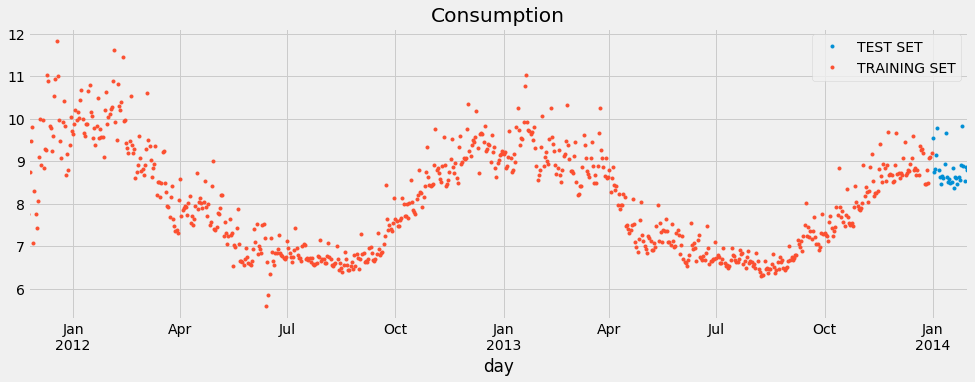

In [427]:
# Plot train and test so you can see where we have split
ts_plot = test.rename(columns={'consumption': 'TEST SET'}).join(train.rename(columns={'consumption': 'TRAINING SET'}),how='outer')
ts_plot.plot(figsize=(15,5), title='Consumption', style='.')
plt.show()

#### Simple Prophet Model

In [428]:
# The prophet package expects input as a dataframe with the first column indicating time and 
train.reset_index(inplace = True)
test.reset_index(inplace = True)

# It also expects these columns to have the names 'ds' and 'y', so we rename them accordingly
train = train.rename(columns={'day': 'ds', 'consumption': 'y'}) 
test = test.rename(columns={'day': 'ds', 'consumption': 'y'}) 
train.head()

,ds,y
0,2011-11-24,7.7580
1,2011-11-25,8.7385
2,2011-11-26,9.4770
3,2011-11-27,9.8030
4,2011-11-28,7.0690


In [429]:
# Setup and train model and fit
model = Prophet(yearly_seasonality=True)
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [430]:
# Predict on training set with model
test_fcst = model.predict(test)
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,7.596571,8.300063,9.227288,7.596571,7.596571,1.150964,1.150964,1.150964,-0.183449,-0.183449,-0.183449,1.334413,1.334413,1.334413,0.0,0.0,0.0,8.747536
1,2014-01-02,7.594358,8.279744,9.188525,7.594358,7.594358,1.134226,1.134226,1.134226,-0.201940,-0.201940,-0.201940,1.336165,1.336165,1.336165,0.0,0.0,0.0,8.728584
2,2014-01-03,7.592145,8.291160,9.236687,7.592145,7.592145,1.177072,1.177072,1.177072,-0.164136,-0.164136,-0.164136,1.341207,1.341207,1.341207,0.0,0.0,0.0,8.769216
3,2014-01-04,7.589932,8.593951,9.537023,7.589932,7.589932,1.474852,1.474852,1.474852,0.125263,0.125263,0.125263,1.349589,1.349589,1.349589,0.0,0.0,0.0,9.064784
4,2014-01-05,7.587718,8.990624,9.948696,7.587718,7.587718,1.910925,1.910925,1.910925,0.549643,0.549643,0.549643,1.361282,1.361282,1.361282,0.0,0.0,0.0,9.498643


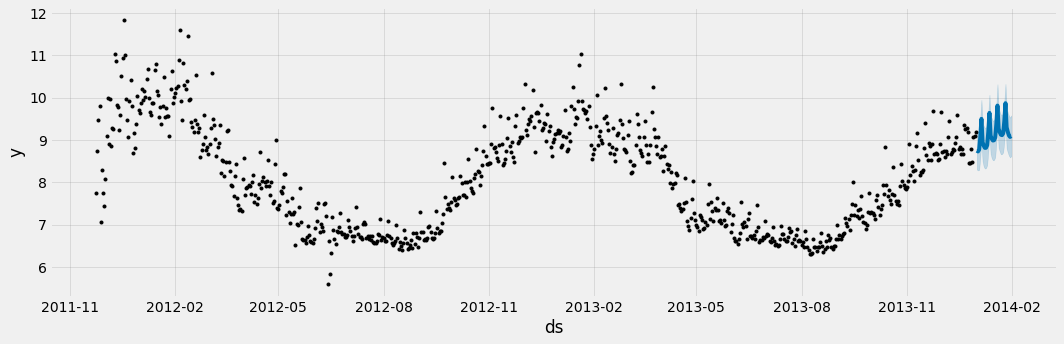

In [431]:
# Plot the forecast
fig, ax = plt.subplots(1, figsize = (15,5))
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

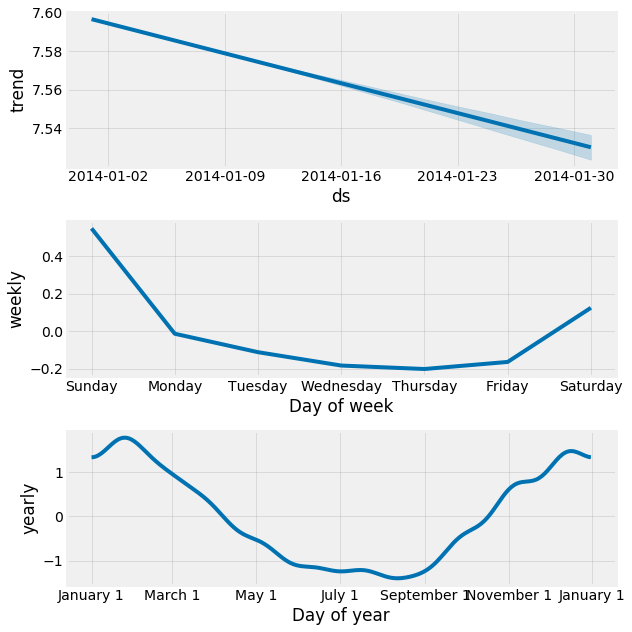

In [432]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

#### Compare Forecast to Actuals

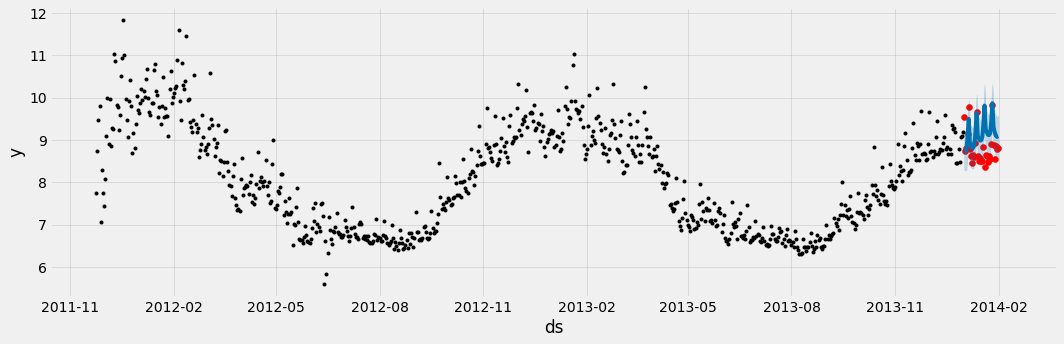

In [434]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(1, figsize = (15,5))
ax.scatter(test['ds'], test['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

In [435]:
test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,7.596571,8.300063,9.227288,7.596571,7.596571,1.150964,1.150964,1.150964,-0.183449,-0.183449,-0.183449,1.334413,1.334413,1.334413,0.0,0.0,0.0,8.747536
1,2014-01-02,7.594358,8.279744,9.188525,7.594358,7.594358,1.134226,1.134226,1.134226,-0.201940,-0.201940,-0.201940,1.336165,1.336165,1.336165,0.0,0.0,0.0,8.728584
2,2014-01-03,7.592145,8.291160,9.236687,7.592145,7.592145,1.177072,1.177072,1.177072,-0.164136,-0.164136,-0.164136,1.341207,1.341207,1.341207,0.0,0.0,0.0,8.769216
3,2014-01-04,7.589932,8.593951,9.537023,7.589932,7.589932,1.474852,1.474852,1.474852,0.125263,0.125263,0.125263,1.349589,1.349589,1.349589,0.0,0.0,0.0,9.064784
4,2014-01-05,7.587718,8.990624,9.948696,7.587718,7.587718,1.910925,1.910925,1.910925,0.549643,0.549643,0.549643,1.361282,1.361282,1.361282,0.0,0.0,0.0,9.498643
5,2014-01-06,7.585505,8.494312,9.408757,7.585505,7.585505,1.362785,1.362785,1.362785,-0.013390,-0.013390,-0.013390,1.376175,1.376175,1.376175,0.0,0.0,0.0,8.948290
6,2014-01-07,7.583292,8.370701,9.332646,7.583292,7.583327,1.282094,1.282094,1.282094,-0.111992,-0.111992,-0.111992,1.394086,1.394086,1.394086,0.0,0.0,0.0,8.865386
7,2014-01-08,7.581078,8.323473,9.287443,7.581055,7.581237,1.231311,1.231311,1.231311,-0.183449,-0.183449,-0.183449,1.414759,1.414759,1.414759,0.0,0.0,0.0,8.812389
8,2014-01-09,7.578865,8.334756,9.288205,7.578731,7.579163,1.235936,1.235936,1.235936,-0.201940,-0.201940,-0.201940,1.437876,1.437876,1.437876,0.0,0.0,0.0,8.814801
9,2014-01-10,7.576652,8.404941,9.366973,7.576399,7.577068,1.298924,1.298924,1.298924,-0.164136,-0.164136,-0.164136,1.463060,1.463060,1.463060,0.0,0.0,0.0,8.875576


#### Try to fix the below date issue

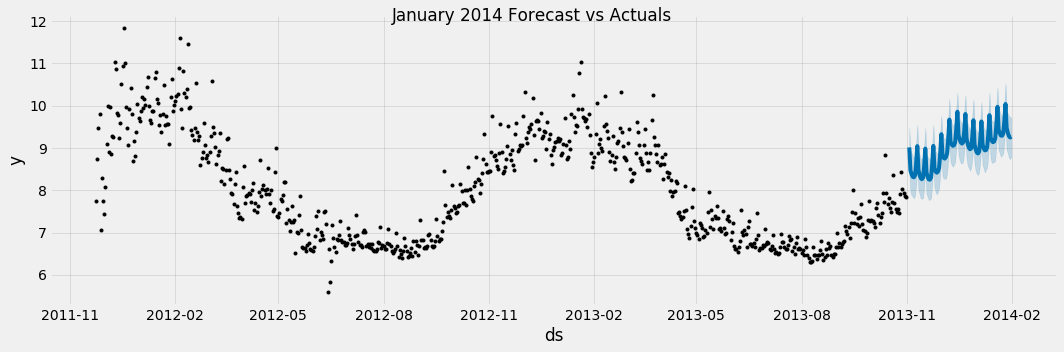

In [346]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(1, figsize = (15,5))
#ax.scatter(test.loc[-90:,'ds'], test.loc[-90:,'y'], color='r')
fig = model.plot(test_fcst[-90:], ax=ax)
# ax.set_xlim(np.datetime64('01-01-2014'), np.datetime64('01-02-2014'))
# ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2014 Forecast vs Actuals')

# times = np.arange('2005-02', '2005-03', dtype='datetime64[D]')

#### Benchmark Accuracy

In [436]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('The MSE is {:.2f}'.format(mean_squared_error(y_true=test['y'], y_pred=test_fcst['yhat'])))
print('The MAE is {:.2f}'.format(mean_absolute_error(y_true=test['y'], y_pred=test_fcst['yhat'])))
print('The MAPE is {:.2f}%'.format(mean_absolute_percentage_error(y_true=test['y'], y_pred=test_fcst['yhat'])))

The MSE is 0.25
The MAE is 0.41
The MAPE is 4.67%


#### Add Some Holidays

In [205]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay

In [355]:
class EnglandAndWalesHolidayCalendar(AbstractHolidayCalendar):
 rules = [
 Holiday('New Years Day', month=1, day=1, observance=next_monday),
 GoodFriday,
 EasterMonday,
 Holiday('Early May bank holiday',
 month=5, day=1, offset=DateOffset(weekday=MO(1))),
 Holiday('Spring bank holiday',
 month=5, day=31, offset=DateOffset(weekday=MO(-1))),
 Holiday('Summer bank holiday',
 month=8, day=31, offset=DateOffset(weekday=MO(-1))),
 Holiday('Christmas Day', month=12, day=25, observance=next_monday),
 Holiday('Boxing Day',
 month=12, day=26, observance=next_monday_or_tuesday)
 ]

cal = EnglandAndWalesHolidayCalendar()

train_holidays = cal.holidays(start=train['ds'].min(),
                              end=train['ds'].max())
test_holidays = cal.holidays(start=test['ds'].min(),
                              end=test['ds'].max())               

In [437]:
# Create a dataframe with holiday, ds columns
time_series['date'] = time_series.index.date
time_series['is_holiday'] = time_series.date.isin([d.date() for d in cal.holidays()])
holiday_df = time_series.loc[time_series['is_holiday']].reset_index().rename(columns={'day':'ds'})
holiday_df['holiday'] = 'UKHoliday'
holiday_df = holiday_df.drop(['consumption','date','is_holiday'], axis=1)
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])
holiday_df.head()

,ds,holiday
0,2011-12-26,UKHoliday
1,2011-12-27,UKHoliday
2,2012-01-02,UKHoliday
3,2012-04-06,UKHoliday
4,2012-04-09,UKHoliday


#### Train and Predict with holidays

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE is 0.25
The MAE is 0.40
The MAPE is 4.66%


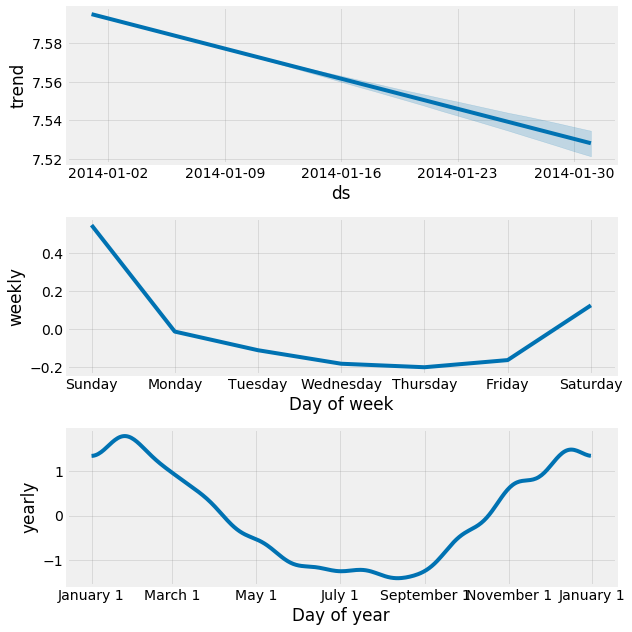

In [471]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df, yearly_seasonality=True)
model_with_holidays.fit(train)
#Predict
# Predict on training set with model
test_fcst_with_hols = model_with_holidays.predict(test)
#Look at Components
fig = model.plot_components(test_fcst_with_hols)
# Accuracy
print('The MSE is {:.2f}'.format(mean_squared_error(y_true=test['y'], y_pred=test_fcst_with_hols['yhat'])))
print('The MAE is {:.2f}'.format(mean_absolute_error(y_true=test['y'], y_pred=test_fcst_with_hols['yhat'])))
print('The MAPE is {:.2f}%'.format(mean_absolute_percentage_error(y_true=test['y'], y_pred=test_fcst_with_hols['yhat'])))

#### Tune parameters

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE is 0.24
The MAE is 0.40
The MAPE is 4.63%


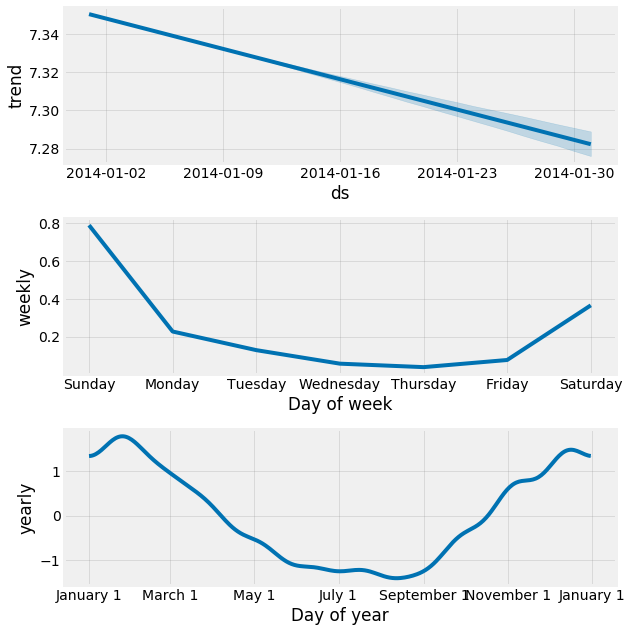

In [515]:
train
# Code to remove any outliers - tries this but didn't make much diffference
# train_no_outliers =train.copy() 
# train_no_outliers.loc[(train_no_outliers['ds'] >= pd.to_datetime('2012-06-13')) &(train_no_outliers['ds'] <= pd.to_datetime('2012-06-16')), 'y'] = None

# Setup and train model with holidays
model2 = Prophet(#holidays=holiday_df, 
                 growth='linear', 
#                  seasonality_mode = 'additive',
#                  seasonality_prior_scale =25,
                 weekly_seasonality=10, 
                 yearly_seasonality=10,)
model2.fit(train)
#Predict
# Predict on training set with model
test_fcst2 = model2.predict(test)
#Look at Components
fig = model2.plot_components(test_fcst2)
# Accuracy
print('The MSE is {:.2f}'.format(mean_squared_error(y_true=test['y'], y_pred=test_fcst2['yhat'])))
print('The MAE is {:.2f}'.format(mean_absolute_error(y_true=test['y'], y_pred=test_fcst2['yhat'])))
print('The MAPE is {:.2f}%'.format(mean_absolute_percentage_error(y_true=test['y'], y_pred=test_fcst2['yhat'])))

#### Plot Forecast Models vs. Actuals

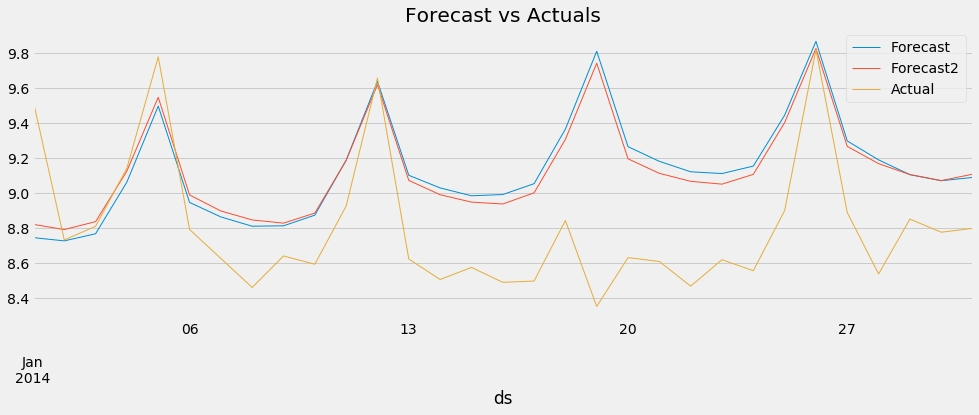

In [500]:
# test.set_index('ds')['y'].plot()
ax = test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=1,
                                                 style='')

ax = test_fcst2.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=1,
                                                 style='')

test.set_index('ds')['y'].plot(ax=ax, style='', lw=1, alpha=1)



plt.legend(['Forecast','Forecast2','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

### Alternative code using fb Prophet

#### Fit model

In [254]:
# now we are ready to fit a forecast model with prophet
forecast_model = Prophet()
# forecast_model = Prophet( growth='linear', seasonality_mode = 'multiplcative', weekly_seasonality=8, yearly_seasonality=8 , monthly_seasonlity =8)
forecast_model.fit( time_series )

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Generate Future Dates
Generate a further 365 days and plot forecast

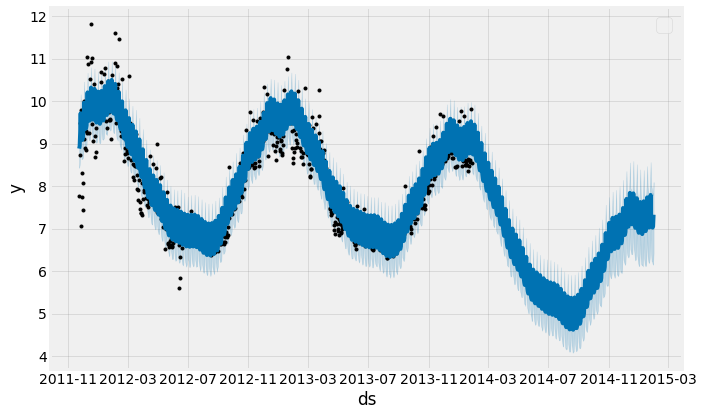

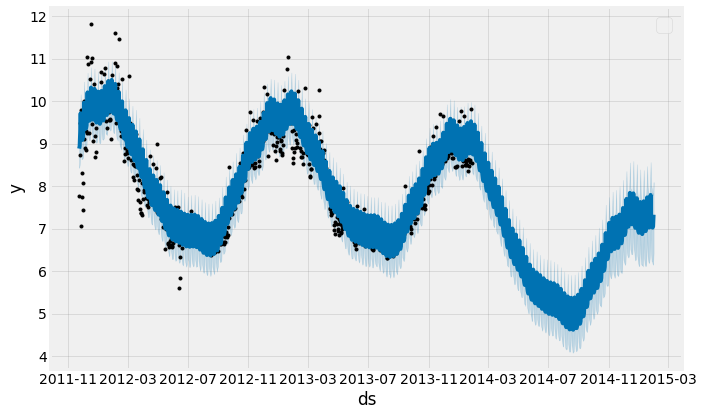

In [517]:
df_dates = forecast_model.make_future_dataframe(periods=365, 
                                                include_history=True)
model_predictions = forecast_model.predict( df_dates )
plot_pred = forecast_model.plot( model_predictions )
plt.legend(loc='best', fontsize=20)
plot_pred

#### Plot the components

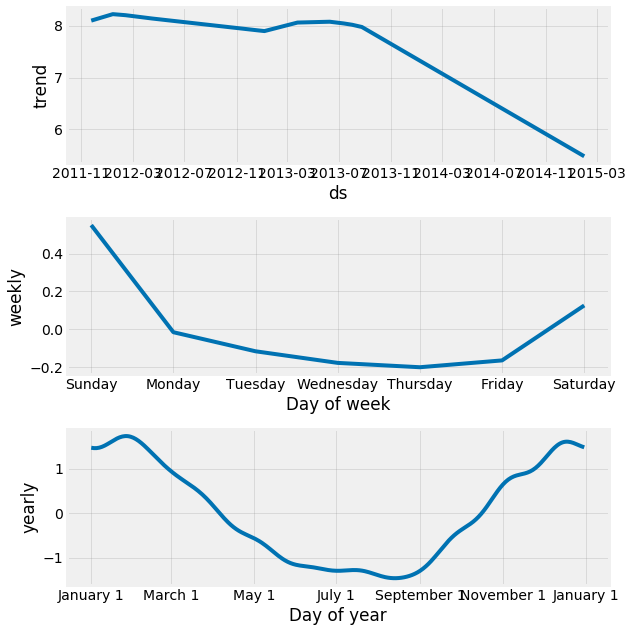

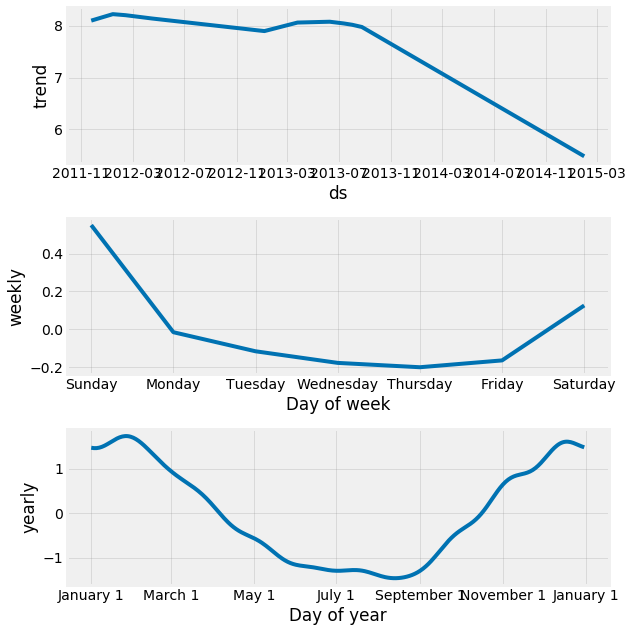

In [519]:
forecast_model.plot_components( forecast_model.predict(df_dates), 
                               uncertainty=False )

In [257]:
# pd.to_datetime(model_predictions['ds']).year()

model_predictions.dtypes
Feb14 = (pd.to_datetime(model_predictions['ds']) >= '2014-02-01') & (pd.to_datetime(model_predictions['ds']) <  '2014-02-28')
# model_predictions.loc[Feb14,'yhat']

In [258]:

date_split = '2014-01-01'
train =  time_series.loc[pd.to_datetime(time_series['ds']) < date_split,'y']
test = time_series.loc[pd.to_datetime(time_series['ds']) >= date_split,'y']
test
pred = model_predictions.loc[(pd.to_datetime(model_predictions['ds']) >= date_split) &  (pd.to_datetime(model_predictions['ds']) <  '2014-02-01'),'yhat']

pred

769    8.657502
770    8.623650
771    8.651117
772    8.935498
773    9.356771
774    8.788573
775    8.688646
776    8.630622
777    8.613227
778    8.657007
779    8.957182
780    9.393371
781    8.838878
782    8.751145
783    8.703541
784    8.694570
785    8.744605
786    9.048738
787    9.486510
788    8.931195
789    8.840254
790    8.787120
791    8.770402
792    8.810617
793    9.103036
794    9.527405
795    8.957227
796    8.850208
797    8.780037
798    8.745585
799    8.767629
Name: yhat, dtype: float64

In [259]:


mean_absolute_percentage_error(y_true=test, y_pred=pred)  #2.57 without holidays  fourier transform 10
mean_absolute_percentage_error(y_true=test, y_pred=pred)  #2.69 without holidays  fourier transform 3 multiplicative
mean_absolute_percentage_error(y_true=test, y_pred=pred)  #2.49 without holidays  fourier transform 10 multiplicative
mean_absolute_percentage_error(y_true=test, y_pred=pred)  #2.56 default model

2.5639012646956694

#### Cross Validation

In [466]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation(model = model2, horizon = '30 days')

INFO:fbprophet:Making 25 forecasts with cutoffs between 2012-12-06 00:00:00 and 2013-12-01 00:00:00


In [520]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-12-07,9.778600,9.365294,10.206752,9.4365,2012-12-06
1,2012-12-08,10.205500,9.763013,10.651803,9.5580,2012-12-06
2,2012-12-09,10.748895,10.312229,11.164411,10.1720,2012-12-06
3,2012-12-10,10.189682,9.739196,10.621148,9.2970,2012-12-06
4,2012-12-11,10.177642,9.733447,10.623112,8.7070,2012-12-06
5,2012-12-12,10.126647,9.698890,10.540474,9.6360,2012-12-06
6,2012-12-13,10.180791,9.745697,10.631358,9.6565,2012-12-06
7,2012-12-14,10.293526,9.840348,10.756664,9.6330,2012-12-06
8,2012-12-15,10.681694,10.227599,11.112878,9.4510,2012-12-06
9,2012-12-16,11.182120,10.749375,11.610407,9.8310,2012-12-06


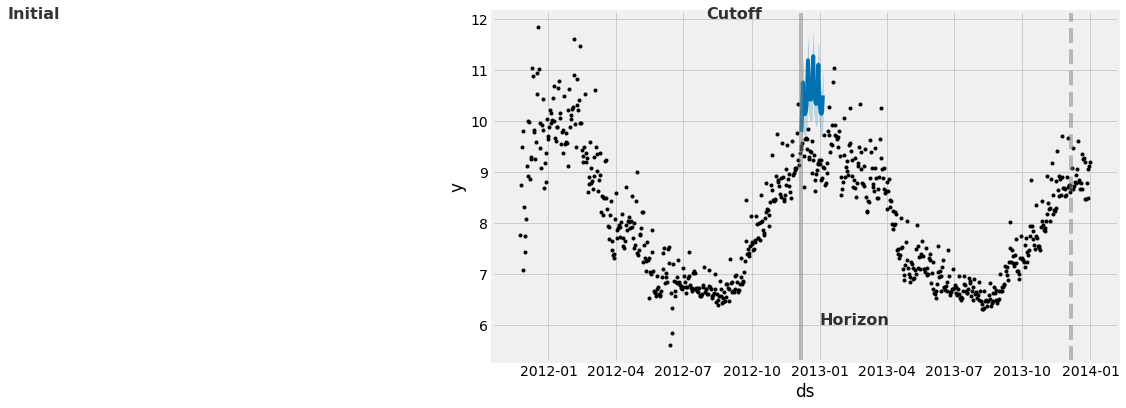

In [468]:
cutoff = cv_results['cutoff'].unique()[0]
cv_results = cv_results[cv_results['cutoff'].values == cutoff]
cv_results
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(model2.history['ds'].values, model2.history['y'], 'k.')
ax.plot(cv_results['ds'].values, cv_results['yhat'], ls='-', c='#0072B2')
ax.fill_between(cv_results['ds'].values, cv_results['yhat_lower'],
                cv_results['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2010-01-01'),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2012-08-01'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2013-01-01'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

In [469]:

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,0.289699,0.538237,0.522165,0.053570,0.056714,0.333333
1,4 days,0.516315,0.718551,0.705692,0.073492,0.067744,0.000000
2,5 days,1.097492,1.047613,0.980073,0.107212,0.096018,0.000000
3,6 days,1.066801,1.032861,0.951324,0.105280,0.096018,0.000000
4,7 days,0.892801,0.944881,0.828527,0.091372,0.054294,0.000000


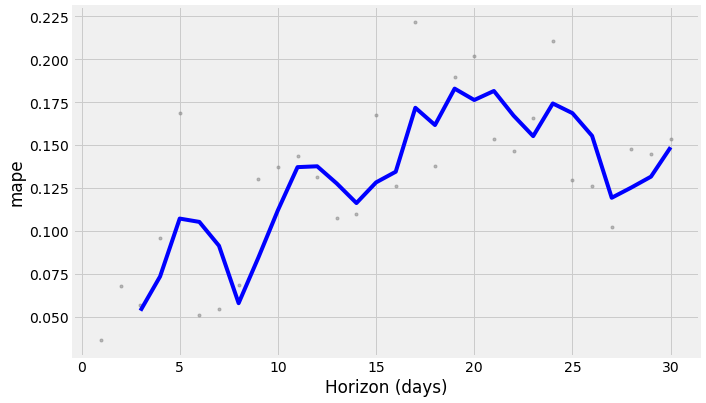

In [470]:

from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='mape')

### Testing Model file

In [68]:
def preprocess(df):
    """This function takes a dataframe and preprocesses it so it is
    ready for the training stage.

    The DataFrame contains the time axis and the target column.

    It also contains some rows for which the target column is unknown.
    Those are the observations you will need to predict for KATE 
    to evaluate the performance of your model.

    Here you will need to return the training time serie: ts together
    with the preprocessed evaluation time serie: ts_eval.

    Make sure you return ts_eval separately! It needs to contain
    all the rows for evaluation -- they are marked with the column
    evaluation_set. You can easily select them with pandas:

         - df.loc[df.evaluation_set]


    :param df: the dataset
    :type df: pd.DataFrame
    :return: ts, ts_eval
    """

    
    df['day'] = pd.to_datetime(df['day'])
    df = df.rename(columns={'day': 'ds', 'consumption': 'y'})
    ts = df[df['evaluation_set'] == False].drop('evaluation_set', axis=1)
    ts_eval = df[df['evaluation_set'] == True].drop('evaluation_set', axis=1)
    return ts, ts_eval
df = pd.read_csv("data/london_smartmeter_basic.csv")
ts, ts_eval = preprocess(df)

In [100]:
ts_eval = df[df['evaluation_set'] == True].drop('evaluation_set', axis=1)
ts_eval

df[~df['evaluation_set']]

,day,consumption,evaluation_set
0,2011-11-24,7.7580,False
1,2011-11-25,8.7385,False
2,2011-11-26,9.4770,False
3,2011-11-27,9.8030,False
4,2011-11-28,7.0690,False
...,...,...,...
795,2014-01-27,8.8905,False
796,2014-01-28,8.5395,False
797,2014-01-29,8.8530,False
798,2014-01-30,8.7780,False


In [70]:
def train(ts):
    """Trains a new model on ts and returns it.

    :param ts: your processed training time serie
    :type ts: pd.DataFrame
    :return: a trained model
    """

    forecast_model = Prophet( growth='linear',  weekly_seasonality=6, yearly_seasonality=7, )

    forecast_model.fit(ts)
    return forecast_model

model = train(ts)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [73]:
ts_eval['ds']

800   2014-02-01
801   2014-02-02
802   2014-02-03
803   2014-02-04
804   2014-02-05
805   2014-02-06
806   2014-02-07
807   2014-02-08
808   2014-02-09
809   2014-02-10
810   2014-02-11
811   2014-02-12
812   2014-02-13
813   2014-02-14
814   2014-02-15
815   2014-02-16
816   2014-02-17
817   2014-02-18
818   2014-02-19
819   2014-02-20
820   2014-02-21
821   2014-02-22
822   2014-02-23
823   2014-02-24
824   2014-02-25
825   2014-02-26
826   2014-02-27
Name: ds, dtype: datetime64[ns]

In [90]:
def predict(model, ts_test):
    """This functions takes your trained model as well 
    as a processed test time serie and returns predictions.

    On KATE, the processed testt time serie will be the ts_eval you built
    in the "preprocess" function. If you're testing your functions locally,
    you can try to generate predictions using a sample test set of your
    choice.

    This should return your predictions either as a pd.DataFrame with one column
    or a pd.Series

    :param model: your trained model
    :param ts_test: a processed test time serie (on KATE it will be ts_eval)
    :return: y_pred, your predictions
    """
    print(ts_test.head())
    dates = ts_test[['ds']]
    predictions = model.predict(dates)['yhat']
    return predictions

In [91]:
pred = predict(model, ts_eval)


            ds   y
800 2014-02-01 NaN
801 2014-02-02 NaN
802 2014-02-03 NaN
803 2014-02-04 NaN
804 2014-02-05 NaN


In [96]:
pred.dtype

dtype('float64')

In [ ]:
mean_absolute_error(metric_df.y, metric_df.yhat)